In [2]:
import galarp as grp
from galarp import InterpolatedWind, InterpolatedDensity

grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u
from astropy.table import Table

from gala.units import galactic
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
from matplotlib import animation

from scipy import stats
from scipy.interpolate import interp1d

from astropy.modeling.models import Gaussian1D, custom_model
from astropy.modeling.fitting import LevMarLSQFitter

# Full dynamic shadowing

Shadowing occurs in ram pressure events when the disk (and other material) "gets in the way" of the ram pressure wind.
It manifests as a reduction of the wind downstream, as clouds work to limit the wind strength over time.

Examples of why this is important:

1. Face-on wind shadows have a higher *volume* than edge-on wind shadows. However, edge-on shadows must be **stronger**,
as the wind is passing through a higher column density of gas.


### How we do it

1. Apply a rotation matrix to our current particle distribution to align the particles with what the wind "sees"

2. Bin the particles by taking a 2D histogram along the wind's line of sight.

3. Determine the shadow using the clouds' z-positions (distance along LOS), using cumulative distribution functions.

This gives us a list of damping values for each cloud, without requiring us to rotating anything back into the original
frame.

In [3]:
orbits = grp.OrbitContainer.load("temp/orbits_JZ_dup.grp")

x,y,z, *_ = grp.get_orbit_data(orbits.data, transposed=False)

wind = grp.LorentzianWind(t0=300*u.Myr, width=200*u.Myr, units=galactic)
wind.init_from_inc(inclination=np.deg2rad(45), strength=800 * u.km/u.s)

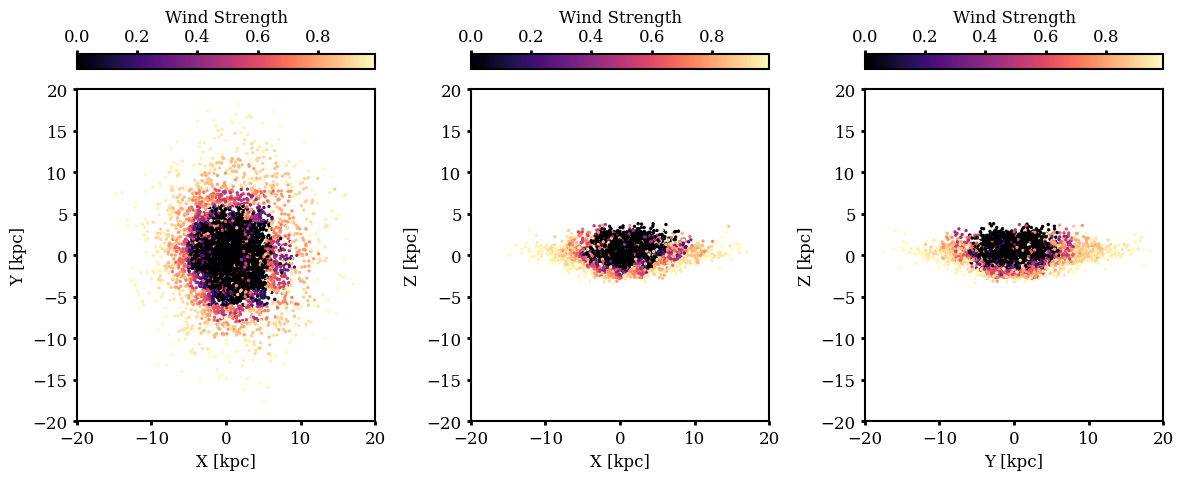

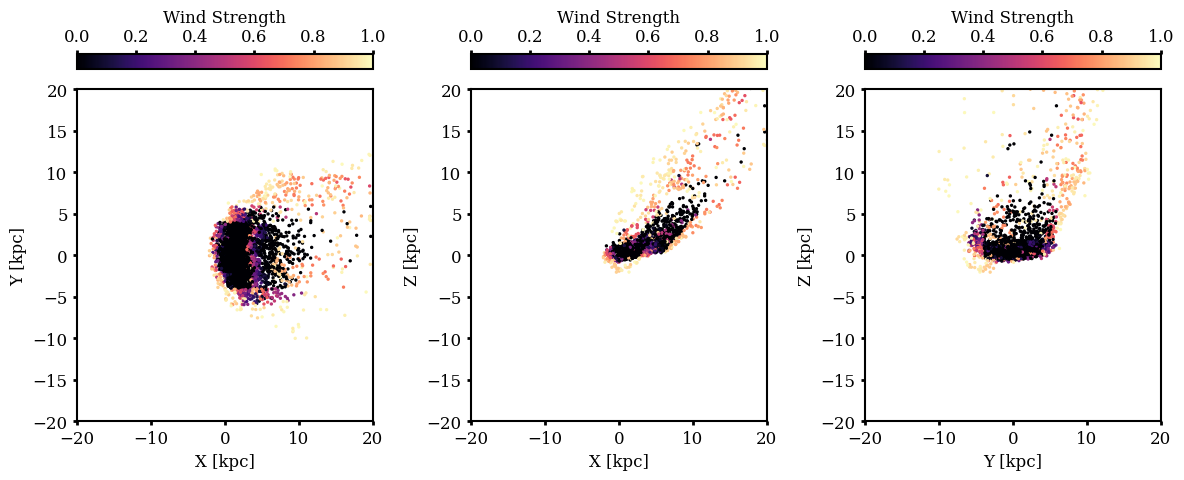

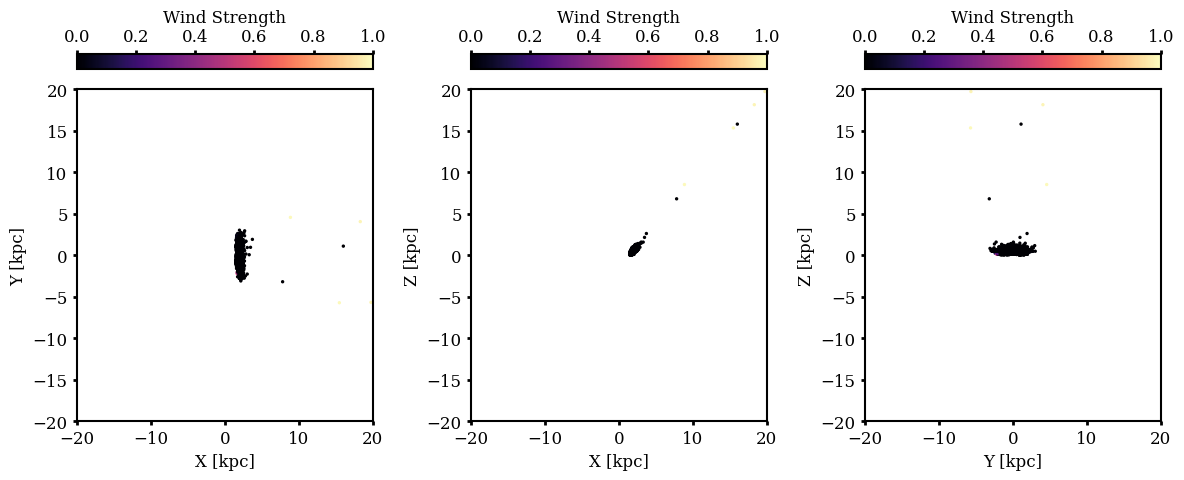

In [6]:
def dynamic_shadow(xyz, wind, depth=0.2, **kwargs):
    debug = kwargs.get("debug", False)
    y_range = kwargs.get("y_range", (-20, 20))
    z_range = kwargs.get("z_range", (-20, 20))
    n_bins = kwargs.get("n_bins", 20)

    cmap = kwargs.get("cmap", "viridis")

    # STEP 1: Rotate the particles to the wind frame    
    xyz_rotated = grp.rotate(xyz, beta=wind.inclination())
    xyz_rotated_T = xyz_rotated.T

    shadowing = np.ones(len(xyz[0]))


    # STEP 2: Bin the particles along the y-z axis to get distribution along wind's line of sight
    # Create bins along the y and z axis
    y_bins = np.linspace(y_range[0], y_range[1], n_bins + 1)
    z_bins = np.linspace(z_range[0], z_range[1], n_bins + 1)


    # Bin particles along y-z axis
    y_bin_indices = np.digitize(xyz_rotated[1], y_bins)
    z_bin_indices = np.digitize(xyz_rotated[2], z_bins)

    shadow_bins = np.linspace(-20, 50, 101)
    z_dist = np.zeros((n_bins, n_bins, len(shadow_bins) - 1))

    tot_particles = 0

    interps = []

    for i in range(n_bins):
        #particles_in_bin = xyz_rotated_T[y_bin_indices == i + 1]
        for j in range(n_bins):
            # Get particles in the bin, and take only the z component
            # We take a cumulative sum of the histogram to get the integrated number of particles at each distance
            
            in_bin = np.bitwise_and(y_bin_indices == i + 1, z_bin_indices == j + 1)

            particles_in_z_bin = xyz_rotated_T[in_bin].T[0]

            tot_particles += len(particles_in_z_bin)

            histsum = np.cumsum(np.histogram(particles_in_z_bin, bins=shadow_bins)[0]) * depth
            #z_dist[i, j] =  1 - np.min([histsum, np.ones(len(histsum))], axis=0)

            interp = interp1d(shadow_bins[:-1], 1 - np.min([histsum, np.ones(len(histsum))], axis=0), 
                              kind="linear", fill_value=(0, 1), bounds_error=False)
            interps.append(interp)
            
            shadowing[in_bin] = interp(xyz_rotated[0][in_bin])

    if debug:
        fig, ax = plt.subplots(1, 3, figsize=(12, 5))

        m1 = ax[0].scatter(xyz[0], xyz[1], c=shadowing, cmap=cmap, s=2)
        ax[0].set(xlabel="X [kpc]", ylabel="Y [kpc]", xlim=(-20, 20), ylim=(-20, 20))

        m2 = ax[1].scatter(xyz[0], xyz[2], c=shadowing, cmap=cmap, s=2)
        ax[1].set(xlabel="X [kpc]", ylabel="Z [kpc]", xlim=(-20, 20), ylim=(-20, 20))

        m3 = ax[2].scatter(xyz[1], xyz[2], c=shadowing, cmap=cmap, s=2)
        ax[2].set(xlabel="Y [kpc]", ylabel="Z [kpc]", xlim=(-20, 20), ylim=(-20, 20))

        plt.colorbar(mappable=m1, ax=ax[0], label="Wind Strength", orientation="horizontal", location="top")
        plt.colorbar(mappable=m2, ax=ax[1], label="Wind Strength", orientation="horizontal", location="top")
        plt.colorbar(mappable=m3, ax=ax[2], label="Wind Strength", orientation="horizontal", location="top")

        plt.tight_layout()
        plt.savefig(f"figures/shadowing/shadow_{index}_{depth}_{n_bins}_{np.rad2deg(wind.inclination()):.0f}.png")


    return shadowing


for index in np.linspace(50, 800, 3).astype(int):
    xyz = np.array([x[index], y[index], z[index]])

    wind = grp.LorentzianWind(t0=300*u.Myr, width=200*u.Myr, units=galactic)
    wind.init_from_inc(inclination=np.deg2rad(45), strength=800 * u.km/u.s)

    damping = dynamic_shadow(xyz, wind, y_range = (-20, 20), z_range=(-20, 20), n_bins=20, 
                            debug=True, cmap="magma", depth=0.01)

#%timeit dynamic_shadow(xyz, wind, n_bins=20, debug=False)

In [7]:
class DynamicShadow:

    def __init__(self, wind, depth=0.2, **kwargs):
        self.depth = depth
        self.wind = wind

        self.shadow_name = "Dynamic"

        self.y_range = kwargs.get("y_range", (-20, 20))
        self.z_range = kwargs.get("z_range", (-20, 20))
        self.n_bins = kwargs.get("n_bins", 20)


        self.x_range = kwargs.get("x_range", (-20, 50))
        self.n_bins_wind_direction = kwargs.get("n_bins_wind_direction", 101)


        self.debug = kwargs.get("debug", False)

    def evaluate(self, q, t):
        """
        Evaluate the shadowing effect on particles dynamically, by rotating particles to the wind-frame of reference
        and then computing line-of sight depths.

        NOTE: In the wind frame, the Y-Z plane is what the wind "sees", and the X-axis is the distance along the
        wind direction.

        Parameters:
        - q: numpy array, shape (3, N)
            Array of particle positions.
        - t: float
            Time parameter (Redundant for this shadow, but might be useful if we implement a changing wind inclination).

        Returns:
        - shadowing: numpy array, shape (N,)
            Array of shadowing values for each particle.
        """

        q = q.T

        # STEP 1: Rotate the particles to the wind frame    
        xyz_rotated = grp.rotate(q, beta=self.wind.inclination())
        xyz_rotated_T = xyz_rotated.T

        shadowing = np.ones(len(q[0]))

        # STEP 2: Bin the particles along the y-z axis to get distribution along wind's line of sight
        # Create bins along the y and z axis
        y_bins = np.linspace(self.y_range[0], self.y_range[1], self.n_bins + 1)
        z_bins = np.linspace(self.z_range[0], self.z_range[1], self.n_bins + 1)

        # Bin particles along y-z axis
        y_bin_indices = np.digitize(xyz_rotated[1], y_bins)
        z_bin_indices = np.digitize(xyz_rotated[2], z_bins)

        shadow_bins = np.linspace(self.x_range[0], self.x_range[1], self.n_bins_wind_direction)

        # Get particles in the bin, and take only the z component
        # We take a cumulative sum of the histogram to get the integrated number of particles at each distance
        for i in range(self.n_bins):
            for j in range(self.n_bins):
                
                # Determine which particles are in this current bin              
                in_bin = np.bitwise_and(y_bin_indices == i + 1, z_bin_indices == j + 1)
                particles_in_z_bin = xyz_rotated_T[in_bin].T[0]


                # Get a cumulative histogram of the particle x directions and make it into an interp object
                # NOTE: This might be improved in the future to speed things up, but good for now
                
                histsum = np.cumsum(np.histogram(particles_in_z_bin, bins=shadow_bins)[0]) * self.depth
                interp = interp1d(shadow_bins[:-1], 1 - np.min([histsum, np.ones(len(histsum))], axis=0), 
                                kind="linear", fill_value=(0, 1), bounds_error=False)
                
                # Apply shadowing to the particles in this bin
                shadowing[in_bin] = interp(xyz_rotated[0][in_bin])

        return shadowing

    def debug_evaluate(self, q, t, **kwargs):
        shadowing = self.evaluate(q, t)

        outname = kwargs.get("outname", None)
        cmap = kwargs.get("cmap", "magma")

        fig, ax = plt.subplots(1, 3, figsize=(12, 5))

        m1 = ax[0].scatter(xyz[0], xyz[1], c=shadowing, cmap=cmap)
        ax[0].set(xlabel="X [kpc]", ylabel="Y [kpc]", xlim=(-20, 20), ylim=(-20, 20))

        m2 = ax[1].scatter(xyz[0], xyz[2], c=shadowing, cmap=cmap)
        ax[1].set(xlabel="X [kpc]", ylabel="Z [kpc]", xlim=(-20, 20), ylim=(-20, 20))

        m3 = ax[2].scatter(xyz[1], xyz[2], c=shadowing, cmap=cmap)
        ax[2].set(xlabel="Y [kpc]", ylabel="Z [kpc]", xlim=(-20, 20), ylim=(-20, 20))

        plt.colorbar(mappable=m1, ax=ax[0], label="Wind Strength", orientation="horizontal", location="top")
        plt.colorbar(mappable=m2, ax=ax[1], label="Wind Strength", orientation="horizontal", location="top")
        plt.colorbar(mappable=m3, ax=ax[2], label="Wind Strength", orientation="horizontal", location="top")

        plt.tight_layout()
        if outname is not None:
            plt.savefig(outname, dpi=kwargs.get("dpi", 200))
            plt.close()
        
depth = 0.01
inc = 45
for index in np.linspace(50, 800, 20).astype(int):
    xyz = np.array([x[index], y[index], z[index]])


    wind = grp.LorentzianWind(t0=300*u.Myr, width=200*u.Myr, units=galactic)
    wind.init_from_inc(inclination=np.deg2rad(inc), strength=800 * u.km/u.s)

    shadow = DynamicShadow(wind, depth=depth, n_bins=20)

    shadow.debug_evaluate(xyz.T, 0, outname=f"figures/shadowing/shadow_{index}_{depth}_{inc:.0f}.png", cmap="magma")




## Testing sims with the dynamic shadow

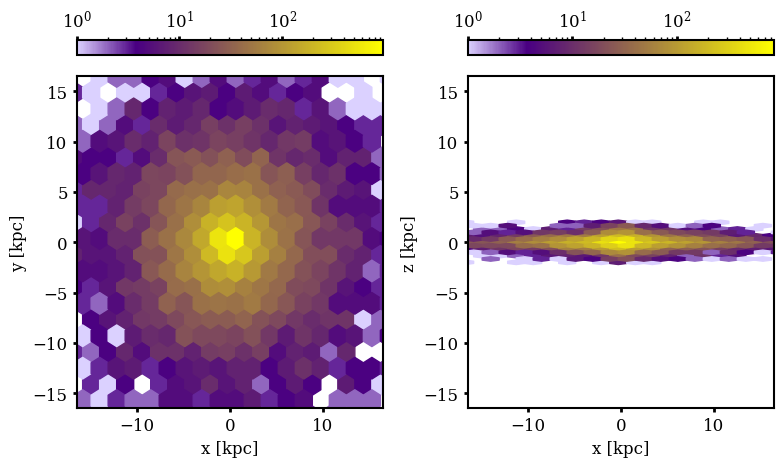

In [9]:
rb2006_satellite = grp.builtins.RB2006_Satellite()

mass_profile = grp.gen_mass_profile(rb2006_satellite)


particles = grp.ExponentialGrid(h_R=rb2006_satellite["gas"].parameters["a"],
                                h_z=rb2006_satellite["gas"].parameters["b"],
                                n_particles=10000)

particles.generate(mass_profile=mass_profile, positions="temp/positions_RB.npy")

particles.plot_density(cmap=cmap, gridsize=30)


In [10]:
orbit_containers = []
incs = [0, 15, 30, 45, 60, 75, 90]

for inclination in [0, 15, 30, 45, 60, 75, 90]:

    rb2006_wind = grp.builtins.RB2006_Wind(inc=inclination)

    shadow = DynamicShadow(rb2006_wind)

    sim = grp.RPSim(wind=rb2006_wind, potential=rb2006_satellite, shadow=shadow, rho_icm=1e-26 * u.g/u.cm**3)

    orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbit_containers.append(orbits)

 29%|██▉       | 116/399 [00:14<00:36,  7.79it/s]/Users/hsouchereau/galarp/galarp/rampressure.py:43: RuntimeWarning: overflow encountered in square
  a_ram = (np.pi * rho.evaluate(t) * r_cloud**2 / m_cloud).to(1 / u.kpc).value * (v_perp**2)
/Users/hsouchereau/gala/gala/integrate/pyintegrators/rk5.py:79: RuntimeWarning: invalid value encountered in multiply
  dw = dw + C[i]*K[i]
 63%|██████▎   | 250/399 [00:34<00:20,  7.15it/s]


KeyboardInterrupt: 

In [ ]:
incs = [0, 15, 30, 45, 60, 75, 90]

for i, inclination in enumerate(incs):

    grp.animated_hexbin_plot(orbit_containers[i], outname=f"figures/rb2006_dynamic_shadow_{inclination}.gif", 
                             cmap=cmap, n_frames=200)

In [11]:
def mstrip(orbits, rmax=20, zmax=5, frac=0.8, **kwargs):
    x,y,z, vx, vy, vz = grp.get_orbit_data(orbits.data, transposed=False)
    

    r = np.sqrt(x**2 + y**2 + z**2)


    this_r_cut = r[np.abs(z) < zmax]
    this_r_cut = this_r_cut[this_r_cut < rmax]
    
    indices = kwargs.get("indices", np.linspace(0, len(x) - 1, 20).astype(int))
    masses = []

    for index in indices:
        
        this_r = r[index]
        this_z = z[index]

        this_r_cut = this_r[np.abs(this_z) < zmax]
        this_r_cut = this_r_cut[this_r_cut < rmax]

        try:
            cdf = stats.ecdf(this_r_cut)
            cdf_xs, cdf_vals = cdf.cdf.quantiles, cdf.cdf.probabilities
            stripped_radius =  np.argmin(np.abs(cdf_vals - frac))
        except Exception:
            stripped_radius = 0

        stripped_mass = stripped_radius * orbits.metadata["M_CLOUD"].to(u.Msun).value

        masses.append(stripped_mass)

    times = orbits.data.t[indices]

    return times, masses

In [33]:
mstrip_times, mstrip_evols = [], []

rstrip_times, rstrips = [], []

for orbit in orbit_containers:
    times, mstrip_evolution = mstrip(orbit, rmax=25, zmax=5, frac=0.8)
    mstrip_times.append(times)
    mstrip_evols.append(mstrip_evolution)

/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)
/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_12704/1346199342.py:5: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2 + z**2)


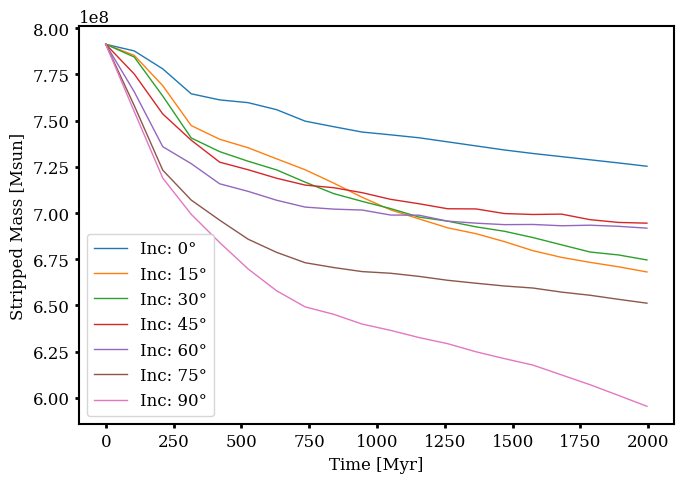

In [36]:
incs = [0, 15, 30, 45, 60, 75, 90]

fig = plt.figure(figsize=(7, 5))

for i in range(len(mstrip_evols)):
    time = mstrip_times[i]
    curve = mstrip_evols[i]
    plt.plot(time, curve, label=f"Inc: {incs[i]}°")

# plt.ylim(5e8, 8e8)
plt.xlabel("Time [Myr]")
plt.ylabel("Stripped Mass [Msun]")
plt.legend()
plt.tight_layout()
plt.savefig("figures/rb2006_mstrip_evolution.png")


In [33]:
orbit_containers_lowdepth = []
incs = [0, 15, 30, 45, 60, 75, 90]
depth = 0.05

for inclination in [0, 15, 30, 45, 60, 75, 90]:

    rb2006_wind = grp.builtins.RB2006_Wind(inc=inclination)

    shadow = DynamicShadow(rb2006_wind, depth=depth)

    sim = grp.RPSim(wind=rb2006_wind, potential=rb2006_satellite, shadow=shadow, rho_icm=1e-26 * u.g/u.cm**3)

    orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbit_containers_lowdepth.append(orbits)



 26%|██▌       | 102/399 [00:14<00:46,  6.45it/s]/Users/hsouchereau/galarp/galarp/rampressure.py:43: RuntimeWarning: overflow encountered in square
  a_ram = (np.pi * rho.evaluate(t) * r_cloud**2 / m_cloud).to(1 / u.kpc).value * (v_perp**2)
/Users/hsouchereau/gala/gala/integrate/pyintegrators/rk5.py:79: RuntimeWarning: invalid value encountered in multiply
  dw = dw + C[i]*K[i]
100%|██████████| 399/399 [01:03<00:00,  6.23it/s]


In [34]:
for i, container in enumerate(orbit_containers_lowdepth):
    container.save(f"temp/orbits_RB2006_{depth}_{incs[i]}.grp")

/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)
/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_62288/1346199342.py:5: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2 + z**2)


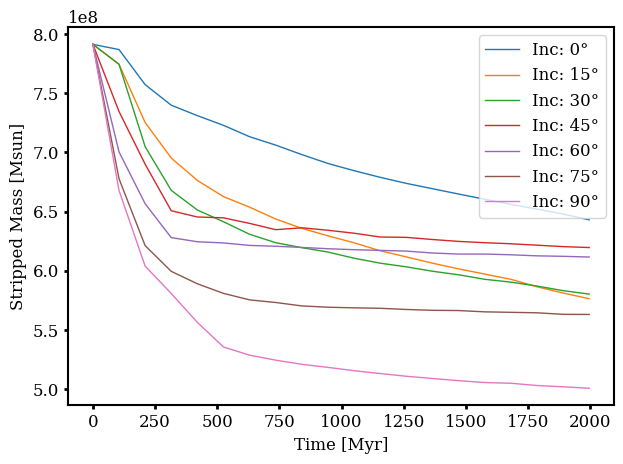

In [35]:
mstrip_times, mstrip_evols = [], []

rstrip_times, rstrips = [], []

for orbit in orbit_containers_lowdepth:
    times, mstrip_evolution = mstrip(orbit, rmax=25, zmax=5, frac=0.8)
    mstrip_times.append(times)
    mstrip_evols.append(mstrip_evolution)


for i in range(len(mstrip_evols)):
    time = mstrip_times[i]
    curve = mstrip_evols[i]
    plt.plot(time, curve, label=f"Inc: {incs[i]}°")

# plt.ylim(5e8, 8e8)
plt.xlabel("Time [Myr]")
plt.ylabel("Stripped Mass [Msun]")
plt.legend()
plt.tight_layout()
plt.savefig("figures/rb2006_mstrip_evolution.png")


In [43]:
def dynamic_shadow_animated_plot(orbits, shadow, **kwargs):

    x,y,z, *_ = grp.get_orbit_data(orbits.data, transposed=False)

    fig, ax = plt.subplots(2, 2, figsize=kwargs.get("figsize", (10, 10)))

    outname = kwargs.get("outname", "animated_hexbin.gif")
    close = kwargs.get("close", True)

    gridsize = kwargs.get("gridsize", 50)
    xextent = kwargs.get("xextent", (-40., 40.))
    xextent = (-xextent, xextent) if isinstance(xextent, (int, float)) else xextent
    yextent = kwargs.get("yextent", (-40., 40.))
    yextent = (-yextent, yextent) if isinstance(yextent, (int, float)) else yextent

    imax = kwargs.get("imax", len(orbits.data.t) - 1)

    vmin, vmax = kwargs.get("vmin", 1), kwargs.get("vmax", 500)

    n_frames = min(kwargs.get("n_frames", 100), imax)

    frames = np.linspace(0, imax, n_frames).astype(int)


    def add_labels(ax):
        ax[0][0].set(ylabel="Y [kpc]", xlim=xextent, ylim=xextent)
        ax[1][0].set(xlabel="Y [kpc]", ylabel="Z [kpc]", xlim=xextent, ylim=yextent)


    cmaps = ["Greys", "Blues", "Greens", "Reds"]
    colors = ["Grey", "Blue", "Green", "Red"]
    damped = [1.0, 0.9, 0.5, 0.1]

    bins = np.linspace(-0.1, 1.1, 23)

    def animate(i):
        this_x, this_y, this_z = x[i], y[i], z[i]

        this_damping = shadow.evaluate(np.array([this_x, this_y, this_z]).T, 0)
        hist, bin_edges = np.histogram(this_damping, bins=bins)

        for axis in ax.flatten()[:]:
            axis.cla()

        ax[1][1].stairs(hist, bin_edges, color="black", lw=2)

        xlims = ax[1][1].get_xlim()
        ylims = ax[1][1].get_ylim()
        dx, dy = xlims[1] - xlims[0], ylims[1] - ylims[0]
        current_time = orbits.data.t[i].value

        ax[1][1].text(xlims[1] - dx /2, ylims[1] - dy / 10, 
                      f"Time: {current_time:.0f} Myr", 
                      ha="left")


        for i in range(len(damped)):
            this_x_damped = this_x[this_damping < damped[i]]
            this_y_damped = this_y[this_damping < damped[i]]
            this_z_damped = this_z[this_damping < damped[i]]

            ax[0][0].hexbin(this_x_damped, this_y_damped, bins="log", cmap=cmaps[i], gridsize=(gridsize, gridsize),
                            extent=[*xextent, *xextent], 
                            vmin=vmin, vmax=vmax, zorder = i + 5)
            
            ax[0][1].hexbin(this_x_damped, this_z_damped, bins="log", cmap=cmaps[i], gridsize=(gridsize, gridsize),
                            extent=[*xextent, *yextent], 
                            vmin=vmin, vmax=vmax, zorder = i + 5)
            ax[1][0].hexbin(this_y_damped, this_z_damped, bins="log", cmap=cmaps[i], gridsize=(gridsize, gridsize),
                            extent=[*xextent, *yextent], 
                            vmin=vmin, vmax=vmax, zorder = i + 5)


            ax[1][1].text(xlims[1] - dx/2,
                          ylims[1] - (i + 2) * dy / 10, 
                          f"d < {damped[i]}: {len(this_x_damped)}", 
                          ha="left", color=colors[i])

        add_labels(ax)

    animate(0)
    plt.tight_layout()
    
    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=100)
    ani.save(outname, writer='pillow', fps=24)

    if close:
        plt.close(fig)
    


    #for i in range()

for index in range(len(orbit_containers_lowdepth)):
    rb2006_wind = grp.builtins.RB2006_Wind(inc=incs[index])

    shadow = DynamicShadow(rb2006_wind, depth=0.01)

    dynamic_shadow_animated_plot(orbit_containers_lowdepth[index], shadow, n_frames=200, imax=200,
                                outname = f"figures/rb2006_shadowing_{incs[index]}.gif")

/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)
/Users/hsouchereau/anaconda3/e

400
